In [ ]:
import sys

sys.path.append('../../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from Pipeline.tf_dataset_builder import RawDatasetBuilder
from Pipeline.preprocess import Normalizer, BandpassFilter
from Pipeline.Cascade.Detection.detection_algorithms import MovingStdDetector
from Pipeline.evaluation import detection_report
from Pipeline.tf_lite_utils import predict_tflite_mtl

In [2]:
seed = 1
np.random.seed(seed)

In [3]:
treeVibes = False

if treeVibes:
    sample_rate = 8000
    #dataset_dir = '../Dataset/TreeVibes/lab/lab/**/*.wav'
    dataset_dir = '../Dataset/TreeVibes/field/field/train/**/**/*.wav'
else:
    sample_rate = 44100
    #dataset_dir = '../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/original_dataset/**/*.wav'
    #dataset_dir = '../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/unprocessed_dataset/**/*.wav'
    dataset_dir = '../Dataset/Final dataset/Evaluation/Collected dataset/**/*.wav'


In [4]:
DatasetBuilder = RawDatasetBuilder(
    dataset_dir=dataset_dir,
    class_dict={'clean': 0, 'infested': 1},
    seed=seed,
    sample_rate=sample_rate,
    balanced=False   # False
)

In [5]:
X_test, y_test = DatasetBuilder.get_features_and_labels()

# Novel approach: multi-task HPS detector
- Load the tflite quantized multi-task network, pretrained on the custom generated dataset
- Split the test set (TreeVibes field) into 2205 samples windows
- Standardize the test set
- Predict on the test set
- Reaggregate the predictions and compute the detection report

In [75]:
X_test_windowed = []
original_indices = []
split_start = []
for j, x in enumerate(X_test):
    splits = []
    for i in range(0, len(x), 2205):
        if len(x[i:i + 2205]) < 2205:
            break
        splits.append(x[i:i + 2205])
        split_start.append(i)

    X_test_windowed.extend(splits)
    # add j to the list as many times as the splits
    original_indices.extend([j] * len(splits))

In [76]:
original_indices = np.array(original_indices)
split_num = np.array(split_start)

In [77]:
if not treeVibes:
    bandpass = BandpassFilter(200, 20000, sample_rate, order=2)
    X_test_windowed = [bandpass.filter(feature) for feature in X_test_windowed]

normalizer = Normalizer(mode='mean_std')
X_test_windowed = [normalizer.normalize(feature) for feature in X_test_windowed]

In [78]:
X_test_windowed = np.array(X_test_windowed)
X_test_windowed = np.expand_dims(X_test_windowed, axis=-1)

In [79]:
y_pred_det, y_pred_class = predict_tflite_mtl('../../Models/mtl_model.tflite', X_test_windowed)

In [80]:
prediction_df = pd.DataFrame({'prediction': y_pred_det.flatten(), 'original_index': original_indices, 'split_start': split_start})
# keep only predictions = 1
anomaly_df = prediction_df[prediction_df['prediction'] == 1]

In [81]:
anomaly_df

,prediction,original_index,split_start
184,1,0,405720
270,1,1,154350
370,1,1,374850
589,1,2,416745
2220,1,11,44100
...,...,...,...
49734,1,248,295470
49777,1,248,390285
50054,1,250,119070
50576,1,252,388080


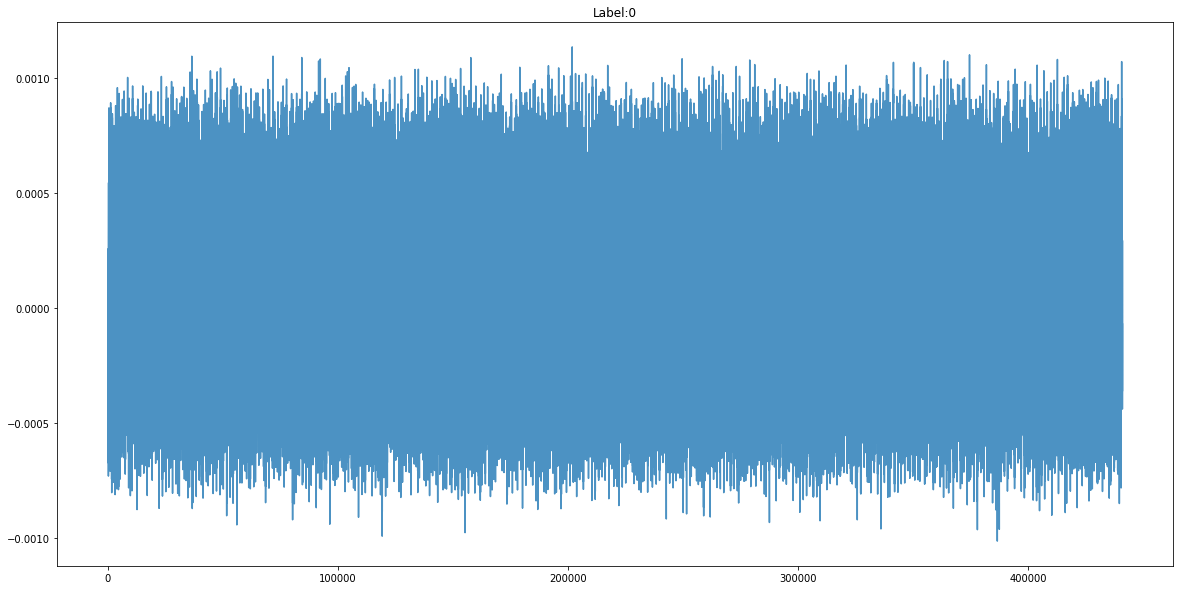

In [82]:
index = 4

plt.figure(figsize=(20, 10))
plt.title('Label:' + str(y_test[index]))
plt.plot(X_test[index], alpha=0.8)
# highlight in red the anomalies
for i, row in anomaly_df[anomaly_df['original_index'] == index].iterrows():
    plt.axvspan(row['split_start'], (row['split_start'] + 2205), color='red', alpha=0.5)

In [83]:
# compute aggregated prediction
aggregated_pred = []
for i in range(len(X_test)):
    # get all the predictions for the current index
    current_index_df = anomaly_df[anomaly_df['original_index'] == i]
    # if there are less than 5 predictions for the current index, append 0
    if len(current_index_df) < 1:
        aggregated_pred.append(0)
    # else append 1 if there is at least one prediction
    else:
        aggregated_pred.append(1)


In [84]:
print("Quantized detection report:")
detection_report(y_test, aggregated_pred)

Quantized detection report:

Evaluation on the test set:
False alarm prob: 38.86%
Miss detection prob: 20.45%
Number of False Positives: 82
Number of False Negatives: 9
Detector f1-score is 43.478261%

Other Metrics:
Detector accuracy is 64.313725%
Detector precision is 29.914530%
Detector recall is 79.545455%


In [85]:
# Classification

prediction_df = pd.DataFrame(
    {'prediction': y_pred_class, 'original_index': original_indices, 'split_start': split_start})
# keep only predictions = 1
anomaly_df = prediction_df[prediction_df['prediction'] != 0]
anomaly_df

,prediction,original_index,split_start
184,2,0,405720
270,1,1,154350
271,1,1,156555
370,1,1,374850
589,1,2,416745
...,...,...,...
49777,1,248,390285
50054,1,250,119070
50344,1,251,317520
50576,1,252,388080


In [106]:
# compute aggregated prediction per class 1 and 2
aggregated_pred = []
for i in range(len(X_test)):
    # get all the predictions for the current index
    current_index_df = anomaly_df[anomaly_df['original_index'] == i]
    # if there are no predictions for the current index, append 0
    if len(current_index_df) == 0:
        aggregated_pred.append(0)
    else:
        # if the majority of the predictions is 1, append 1
        if current_index_df['prediction'].value_counts().index[0] == 1:
            aggregated_pred.append(1)
        # else append 2
        else:
            aggregated_pred.append(2)

In [107]:
aggregated_pred_df = pd.DataFrame({'prediction': aggregated_pred, 'label': y_test})

In [108]:
aggregated_pred_df[aggregated_pred_df['label'] == 1]

,prediction,label
211,1,1
212,1,1
213,0,1
214,1,1
215,1,1
216,1,1
217,1,1
218,1,1
219,1,1
220,1,1


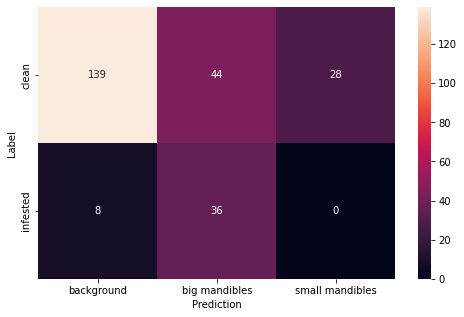

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test , aggregated_pred)

plt.figure(figsize=(8, 5))
sns.heatmap(cm[0:2],
            xticklabels=['background', 'big mandibles', 'small mandibles'],
            yticklabels=['clean', 'infested'],
            annot=True, fmt='g', cmap="rocket")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Cascade Approach

In [42]:
X_test_windowed = []
original_indices = []
split_start = []
for j, x in enumerate(X_test):
    splits = []
    for i in range(0, len(x), 2205):
        if len(x[i:i + 2205]) < 2205:
            break
        splits.append(x[i:i + 2205])
        split_start.append(i)

    X_test_windowed.extend(splits)
    # add j to the list as many times as the splits
    original_indices.extend([j] * len(splits))

original_indices = np.array(original_indices)
split_num = np.array(split_start)


bandpass = BandpassFilter(200, 20000, sample_rate, order=2)
X_test_windowed = [bandpass.filter(feature) for feature in X_test_windowed]

X_test_windowed = np.array(X_test_windowed)

In [71]:
# Moving std detector (adaptive)
detector = MovingStdDetector(version='fixed')
detector.set_params(window_size=50, grace_period=30, factor=0.0015)
y_pred_det_cascade = detector.detect(X_test_windowed)

In [72]:
prediction_df = pd.DataFrame(
    {'prediction': y_pred_det_cascade, 'original_index': original_indices, 'split_start': split_start})
# keep only predictions = 1
anomaly_df = prediction_df[prediction_df['prediction'] != 0]
anomaly_df

,prediction,original_index,split_start
370,True,1,374850
15462,True,77,136710
15626,True,78,57330
15627,True,78,59535
17944,True,89,317520
...,...,...,...
46919,True,234,262395
46936,True,234,299880
47696,True,238,211680
48303,True,241,227115


In [74]:
# compute aggregated prediction
aggregated_pred = []
for i in range(len(X_test)):
    # get all the predictions for the current index
    current_index_df = anomaly_df[anomaly_df['original_index'] == i]
    # if there are less than 5 predictions for the current index, append 0
    if len(current_index_df) < 1:
        aggregated_pred.append(0)
    # else append 1 if there is at least one prediction
    else:
        aggregated_pred.append(1)

print("Cascade detection report:")
detection_report(y_test, aggregated_pred)

Cascade detection report:

Evaluation on the test set:
False alarm prob: 4.74%
Miss detection prob: 56.82%
Number of False Positives: 10
Number of False Negatives: 25
Detector f1-score is 52.054795%

Other Metrics:
Detector accuracy is 86.274510%
Detector precision is 65.517241%
Detector recall is 43.181818%
